# Dense Model


## Section for Configurations and Imports

In [1]:
import os 
import tempfile

import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
from tensorflow import keras

# MLflow dashboard
import mlflow
mlflow.set_tracking_uri('http://35.228.45.76:5000')
os.environ['GOOGLE_APPLICATION_CREDENTIALS']='../../keys/mlflow-312506-8cfad529f4fd.json'

# Import data augmentation
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from augmentation.methods import *

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
random_state = 47
np.random.seed(random_state)

In [4]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# 1. Data Preparation

## 1. Load Prepared Dataset

In [5]:
data_path = '../../datasets/'
files = [
    'posenet_scored_all_1.csv',
    'posenet_scored_all_2.csv',
    'posenet_scored_all_3.csv',
    'posenet_scored_all_4.csv',
]
df = None

In [6]:
for file in files:
    try:
        dataset = pd.read_csv(data_path + file)

        if df is None:
            df = dataset
        else:
            df = df.append(dataset, ignore_index=True)  

    except IOError as e:
        print('Error in reading file: ', e)

print(df.shape)

(225092, 54)


## 2. Split

In [7]:
X = df.drop(columns=['ConfidenceScore', 'GoodnessScore'])
y = df[['ConfidenceScore', 'GoodnessScore']]

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)

In [9]:
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)
print('Training features shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')
print('Test features shape:', X_test.shape)
print('Test labels shape:', y_test.shape)

Training features shape: (202582, 52)
Training labels shape: (202582, 2) 

Test features shape: (22510, 52)
Test labels shape: (22510, 2)


## 3. Define the Model

### 3.1 Configurations

In [10]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Dropout, Flatten

EPOCHS = 500
BATCH_SIZE = 150

input_dim = X_train.shape[1]
output_size = 2

units = 64
activation = 'relu'
#kernel_initializer = 'he_uniform'
kernel_initializer = 'normal'
#output_activation = 'sigmoid'
#output_activation = 'sigmoid'
output_activation = 'linear'
optimizer = 'Adam'
#optimizer = 'rmsprop'
learning_rate = 1e-3

### 3.2 Model Architecture

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer

#METRICS = [
#    keras.metrics.MeanSquaredError(name="mean_squared_error"),
#    keras.metrics.RootMeanSquaredError(name="root_mean_squared_error"),
#    keras.metrics.MeanAbsoluteError(name="mean_absolute_error"),
#    keras.metrics.MeanAbsolutePercentageError(name="mean_absolute_percentage_error"),
#]

from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError


METRICS = [
    MeanSquaredError(name="mse", dtype=None),
    MeanAbsoluteError(name="mae", dtype=None),
    RootMeanSquaredError(name="rmse", dtype=None),
]

def make_model(input_dim, loss, optimizer, learning_rate=0.001, metrics=METRICS):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, kernel_initializer=kernel_initializer, activation=activation))
    model.add(Dense(64, kernel_initializer=kernel_initializer, activation=activation))
    model.add(Dense(32, kernel_initializer=kernel_initializer, activation=activation))
    model.add(Dense(8, kernel_initializer=kernel_initializer, activation=activation))
    model.add(Dense(output_size, activation=output_activation))
    
    
    optimizer = tf.keras.optimizers.get(optimizer)
    optimizer.learning_rate.assign(learning_rate)

    model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=metrics)

    print(model.summary())

    return model

## 4. MLflow Experimentation

### 4.1 Configurations

In [12]:
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec

input_schema = Schema([
    ColSpec("double", "head_x"),
    ColSpec("double", "head_y"),
    ColSpec("double", "left_shoulder_x"),
    ColSpec("double", "left_shoulder_y"),
    ColSpec("double", "right_shoulder_x"),
    ColSpec("double", "right_shoulder_y"),
    ColSpec("double", "left_elbow_x"),
    ColSpec("double", "left_elbow_y"),
    ColSpec("double", "right_elbow_x"),
    ColSpec("double", "right_elbow_y"),
    ColSpec("double", "left_wrist_x"),
    ColSpec("double", "left_wrist_y"),
    ColSpec("double", "right_wrist_x"),
    ColSpec("double", "right_wrist_y"),
    ColSpec("double", "left_hip_x"),
    ColSpec("double", "left_hip_y"),
    ColSpec("double", "right_hip_x"),
    ColSpec("double", "right_hip_y"),
    ColSpec("double", "left_knee_x"),
    ColSpec("double", "left_knee_y"),
    ColSpec("double", "right_knee_x"),
    ColSpec("double", "right_knee_y"),
    ColSpec("double", "left_ankle_x"),
    ColSpec("double", "left_ankle_y"),
    ColSpec("double", "right_ankle_x"),
    ColSpec("double", "right_ankle_y")
])
output_schema = Schema([
    ColSpec("boolean", "quality")
])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

### 4.2 Helper functions

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

In [14]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

def eval_metrics(actual, pred):
    mse = mean_squared_error(actual, pred)
    msa = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    variance = explained_variance_score(actual, pred)
    return mse, msa, r2, variance

### 4.3 Start Run

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                3392      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 18        
Total params: 9,914
Trainable params: 9,914
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
1081/1081 - 2s - loss: 0.3526 - mse: 0.3526 - mae: 0.3635 - rmse: 0.5938 - val_loss: 0.2791 - val_mse: 

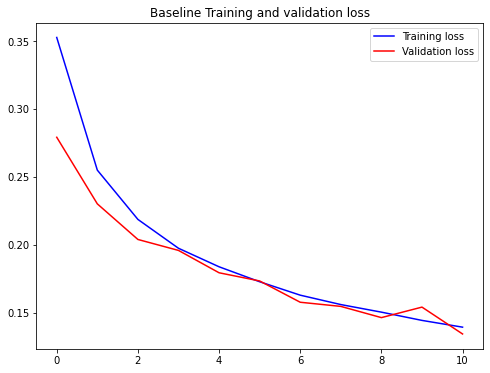

<Figure size 576x432 with 0 Axes>

INFO:tensorflow:Assets written to: /var/folders/8b/c37c7tv54lg10kt29r67dkh80000gn/T/tmp8a2y7rc9/model/data/model/assets
MSE:  0.2877947064619924
MSE:  0.2947005688612547
R-Squared:  0.7206079664507261
Explained Variance Score:  0.7213480460327146


In [15]:
model_name = 'dense_model_confidence_goodness'
#binary_crossentropy
with mlflow.start_run(run_name=model_name) as run:

    run_id = run.info.run_id

    model = make_model(metrics=METRICS, 
                        loss='mean_squared_error', 
                        optimizer=optimizer, 
                        learning_rate=learning_rate, 
                        input_dim=input_dim)
    
    with tf.device('/CPU:0'):
        history = model.fit(
            x=X_train, 
            y=y_train, 
            shuffle=True, 
            epochs=EPOCHS, 
            verbose=2,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            callbacks=[early_stopping])

        # Plot training history
    plot_train_history(history, 'Baseline Training and validation loss')
    plt.savefig("training_history.jpg")
    mlflow.log_artifact("training_history.jpg")
    plt.show()

    # Log model parameters
    mlflow.log_param("activation", activation)
    mlflow.log_param("kernel initializer", kernel_initializer)
    mlflow.log_param("output activation", output_activation)
    mlflow.log_param("optimizer", optimizer)
    mlflow.log_param("learning rate", learning_rate)
    mlflow.log_param("batch size", BATCH_SIZE)
    mlflow.log_param("epochs", early_stopping.stopped_epoch)

    # Log model performance
    process_time = [None] * 10
    
    for i in range(10):
        start_time = time.time()
        predictions = model.predict(X_test)
        end_time = time.time()
        process_time[i] = (end_time - start_time) * 1000
    
    predictions = y_scaler.inverse_transform(predictions)
    (mse, mae, r2, variance) = eval_metrics(y_test, predictions)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("R-squared", r2)
    mlflow.log_metric("variance", variance)
    mlflow.log_param("total params", model.count_params())
    mlflow.log_metric("process time", np.mean(process_time)) 

    # Log model and scaler(s)
    mlflow.keras.log_model(model, model_name, signature=signature)
    mlflow.sklearn.log_model(X_scaler, 'InputScaler')
    mlflow.sklearn.log_model(y_scaler, 'OutputScaler')
    
    # Print metrics
    print('MSE: ', mse)
    print('MSE: ', mae)
    print('R-Squared: ', r2)
    print('Explained Variance Score: ', variance)

## 5. Register Model

In [16]:
model_uri = "runs:/{}/{}".format(run.info.run_id, model_name)
mv = mlflow.register_model(model_uri, model_name)
print("Name: {}".format(mv.name))
print("Version: {}".format(mv.version))

Registered model 'dense_model_confidence_goodness' already exists. Creating a new version of this model...
2021/05/25 16:14:44 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: dense_model_confidence_goodness, version 15


Name: dense_model_confidence_goodness
Version: 15


Created version '15' of model 'dense_model_confidence_goodness'.
